# Übung 3 - Merkmalsextraktion 

## Aufgabenbeschreibung

Das Ziel dieser Übung ist es, den prinzipiellen Ablauf einer Bildanalyse (inkl. einzelne Teilschritte) auf ein Bild aunzuwenden und somit auch den Zusammenhang einzelner Operationen besser nachzuvollziehen.

![AblaufBildanalyse](AblaufBildanalyse.png)




### Generelle Hinweise zur Bearbeitung: 

Die Herausforderung hierbei ist, dass mehrere Phasen der Bildverarbeitung aufeinander aufbauend umgesetzt werden müssen. Zudem ist die Planung sowie die Durchführung des Lösungsweges (ohne konkrete Vorgaben) Ihnen überlassen. Jedoch sollten Sie folgende allgemeine und hilfreiche "Werkzeuge" ins Betracht ziehen:

**Phasen der Bildverarbeitung:**
1.	Bild öffnen
2.	Bildvorverarbeitung
3.	Segmentierung
4.	Objekterkennung
5.	Analyse
6.	Visualisierung

**Zur Segmentierung:**
1.	Iterative Berechnung des optimalen Schwellenwertes
2.	Histogrammanalyse für multimodale Histogramme

**Zur Objekterkennung**
1.	Algorithmus zur Detektion von Kreisen
2.	Hough-Transformation
3.	Skelettierung



### Hinweise zur Abgabe und zur Benotung

- Füllen Sie unbedingt die erste Zelle unterhalb der Überschrift mit Name und Matr.-Nr. aus!
- Ergänzen Sie den Dateinamen des Notebooks vor der Abgabe um `_` und Ihre Matr.-Nr. (`Uebung 1 - Biosignale_s0500000_s0500001.ipynb`).
- Entfernen Sie vor dem Upload alle Ausgaben aus dem Notebook!
- Die Bilddatei muss nicht abgegeben werden.
- Die Aufgabe wird nach dem üblichen Notenschema von 1,0 bis 5,0 bewertet.
- Diese Aufgabe wird mit 40% in der Gesamtnote der Übung gewichtet.

### Viel Erfolg!

## Aufgabenbeschreibung

Lesen Sie `roentgen.tif` mit Hilfe der `matplotlib`-Bibliothek ein. Visualisieren Sie das, in der Datei enthaltene Bild (verwenden Sie die Funktionen `imshow` und `show`).

1.	Berechnen Sie die Anzahl der Finger im Bild.
2.	Finden Sie die Knochen und die Hand. Berechnen Sie dazu den Anteil der Knochen an der Gesamtfläche der Hand.
3.	Berechnen Sie die Anzahl gesamten (einzelnen) Knochen.
 
**Bonus:** 
4. Berechnen Sie die zusätzlich zur Anzahl auch die maximale Länge jedes Knochens.

In [1]:
#%%html
#<style>
#.output_wrapper, .output {
#    height:auto !important;
#    max-height:100000px;  /* your desired max-height here */
#}
#.output_scroll {
#    box-shadow:none !important;
#    webkit-box-shadow:none !important;
#}
#</style>

Hand 1 : 363567.5 --> 24.56%
Found 5 fingers
Hand 2 : 387746.0 --> 26.2%
Found 5 fingers
Total finger Count: 10


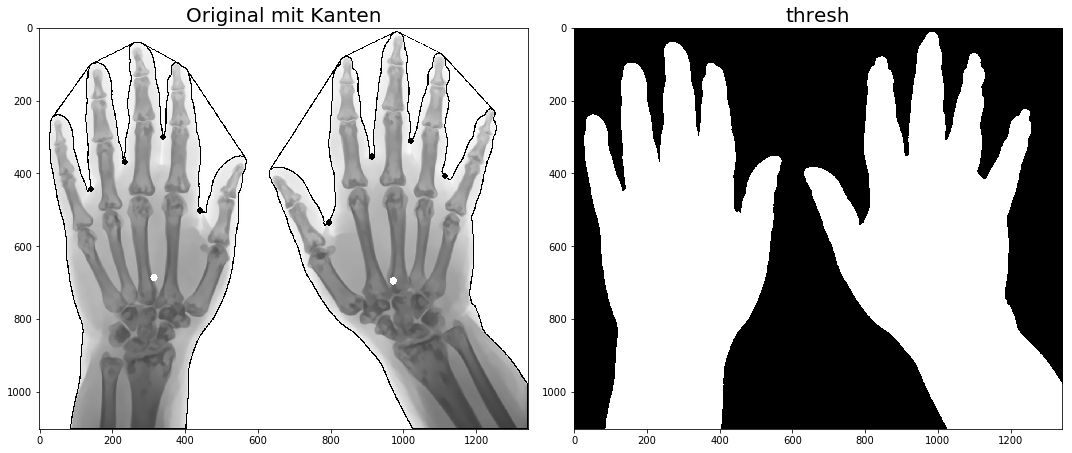

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage.filters as filters

#
# 1. Berechnen Sie die Anzahl der Finger im Bild.
#

# Bild öffnen
img = plt.imread('Testbild_Roentgen2.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.fastNlMeansDenoising(img, None,10,7,21)
img = cv2.bitwise_not(img)

def prepareXRayImg(img):
    ret, thresh = cv2.threshold(img, 250, 255, cv2.THRESH_TRUNC)
    t = filters.threshold_triangle(thresh)
    ret, thresh = cv2.threshold(img, t, 255, cv2.THRESH_BINARY_INV)
    return thresh

def getHandDefects(handArea):
    # Kanten schließen
    handAreaApprox = cv2.approxPolyDP(handArea, 0.02 * cv2.arcLength(handArea, True), True)
    hull = cv2.convexHull(handArea)
    hull = cv2.convexHull(handArea, returnPoints = False)
    defects = cv2.convexityDefects(handArea, hull)
    return defects

def calculateCenterPoint(handArea):
    # "Mittelpunkt" der Hand berechnen
    handRect = cv2.minAreaRect(handArea)
    cX = int(handRect[0][0])
    cY = int(handRect[0][1] * 1.2)
    return cX, cY

def countFingers(handArea): 
    defects = getHandDefects(handArea)
    
    # "Mittelpunkt" der Hand berechnen
    cX, cY = calculateCenterPoint(handArea)
    cv2.circle(img, (cX, cY), 5, (255, 255, 255), 10)

    fingerCnt = 0
    for i in range(defects.shape[0]):
        # [ start point, end point, farthest point, approximate distance to farthest point ]
        s,e,f,d = defects[i,0]
        start = tuple(handArea[s][0])
        end = tuple(handArea[e][0])
        far = tuple(handArea[f][0])
        
        # "approximate distance to farthest point" größer als 8000 und
        # höher als Handmitte
        if(d > 8000 and far[1] < cY):
            cv2.line(img, start, end, [0,255,0],2)
            cv2.circle(img, far, 5, [0,0,255], 5)
            fingerCnt += 1
    
    if(fingerCnt != 0):
        fingerCnt += 1
        
    return fingerCnt

thresh = prepareXRayImg(img)

# Kanten finden
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)

height, width = img.shape
totalArea = height * width

totalFingerCount = 0
handCounter = 0
for c in contours:
    area = cv2.contourArea(c)

    # Bereich nur als Hand akzeptieren wenn Bereich mindestens 13%
    # des gesamten Bildes ausmacht
    percent = area / totalArea * 100
    if(percent > 13):
        print("Hand", (handCounter + 1),':', area,'-->', str(round(percent, 2)) + "%")
        fingerCount = countFingers(c)
        print("Found " + str(fingerCount) + " fingers")
        totalFingerCount += fingerCount
        cv2.drawContours(img, [c], 0, (0,0,0), 2)
        handCounter += 1
    
print("Total finger Count:", totalFingerCount)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax = axes.ravel()

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Originalbild mit Kanten', fontsize=20)

ax[1].imshow(thresh, cmap='gray')
ax[1].set_title('thresh', fontsize=20)

plt.tight_layout()
plt.show()


In [10]:
class Bone:
    x = 0
    y = 0
    width = 0
    height = 0
    size = 0
    boneType = ""
    
    def __repr__(self):
        return "x: " + str(self.x) + " y: " + str(self.y) + " width: " + str(self.width) + " height: " + str(self.height) + " boneType:" + str(self.boneType)
    
    def __init__(self, x, y, width, height, boneType):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.size = width * height
        self.boneType = boneType

Hand: 1 363567.5 24.56%
Hand  1  Bereich Gesamt: 363567.5 --> davon Knochen: 49.33% (179352.5)
Schwellenwert THRESH_MERGE_DIST: 28
Schwellenwert THRESH_BONE_HEIGHT: 19
Schwellenwert THRESH_BONE_WIDTH: 19
8 Knochen zusammengeführt
Knochen typ:     other 	 Länge:       22.3 Rotation:      138.0 Seiten Verhältnis: 1.12
Knochen typ:     other 	 Länge:       33.7 Rotation:      173.4 Seiten Verhältnis: 1.61
Knochen typ:     other 	 Länge:       63.0 Rotation:       90.0 Seiten Verhältnis: 2.03
Knochen typ:     other 	 Länge:       35.9 Rotation:      170.0 Seiten Verhältnis: 1.29
Knochen typ:     other 	 Länge:       28.3 Rotation:      135.0 Seiten Verhältnis: 1.21
Knochen typ:     other 	 Länge:       27.8 Rotation:      143.6 Seiten Verhältnis: 1.08
Knochen typ:     other 	 Länge:       38.9 Rotation:       13.1 Seiten Verhältnis: 1.6
Knochen typ:     other 	 Länge:       41.0 Rotation:      180.0 Seiten Verhältnis: 1.64
Knochen typ:     other 	 Länge:      137.2 Rotation:      103.3 Sei

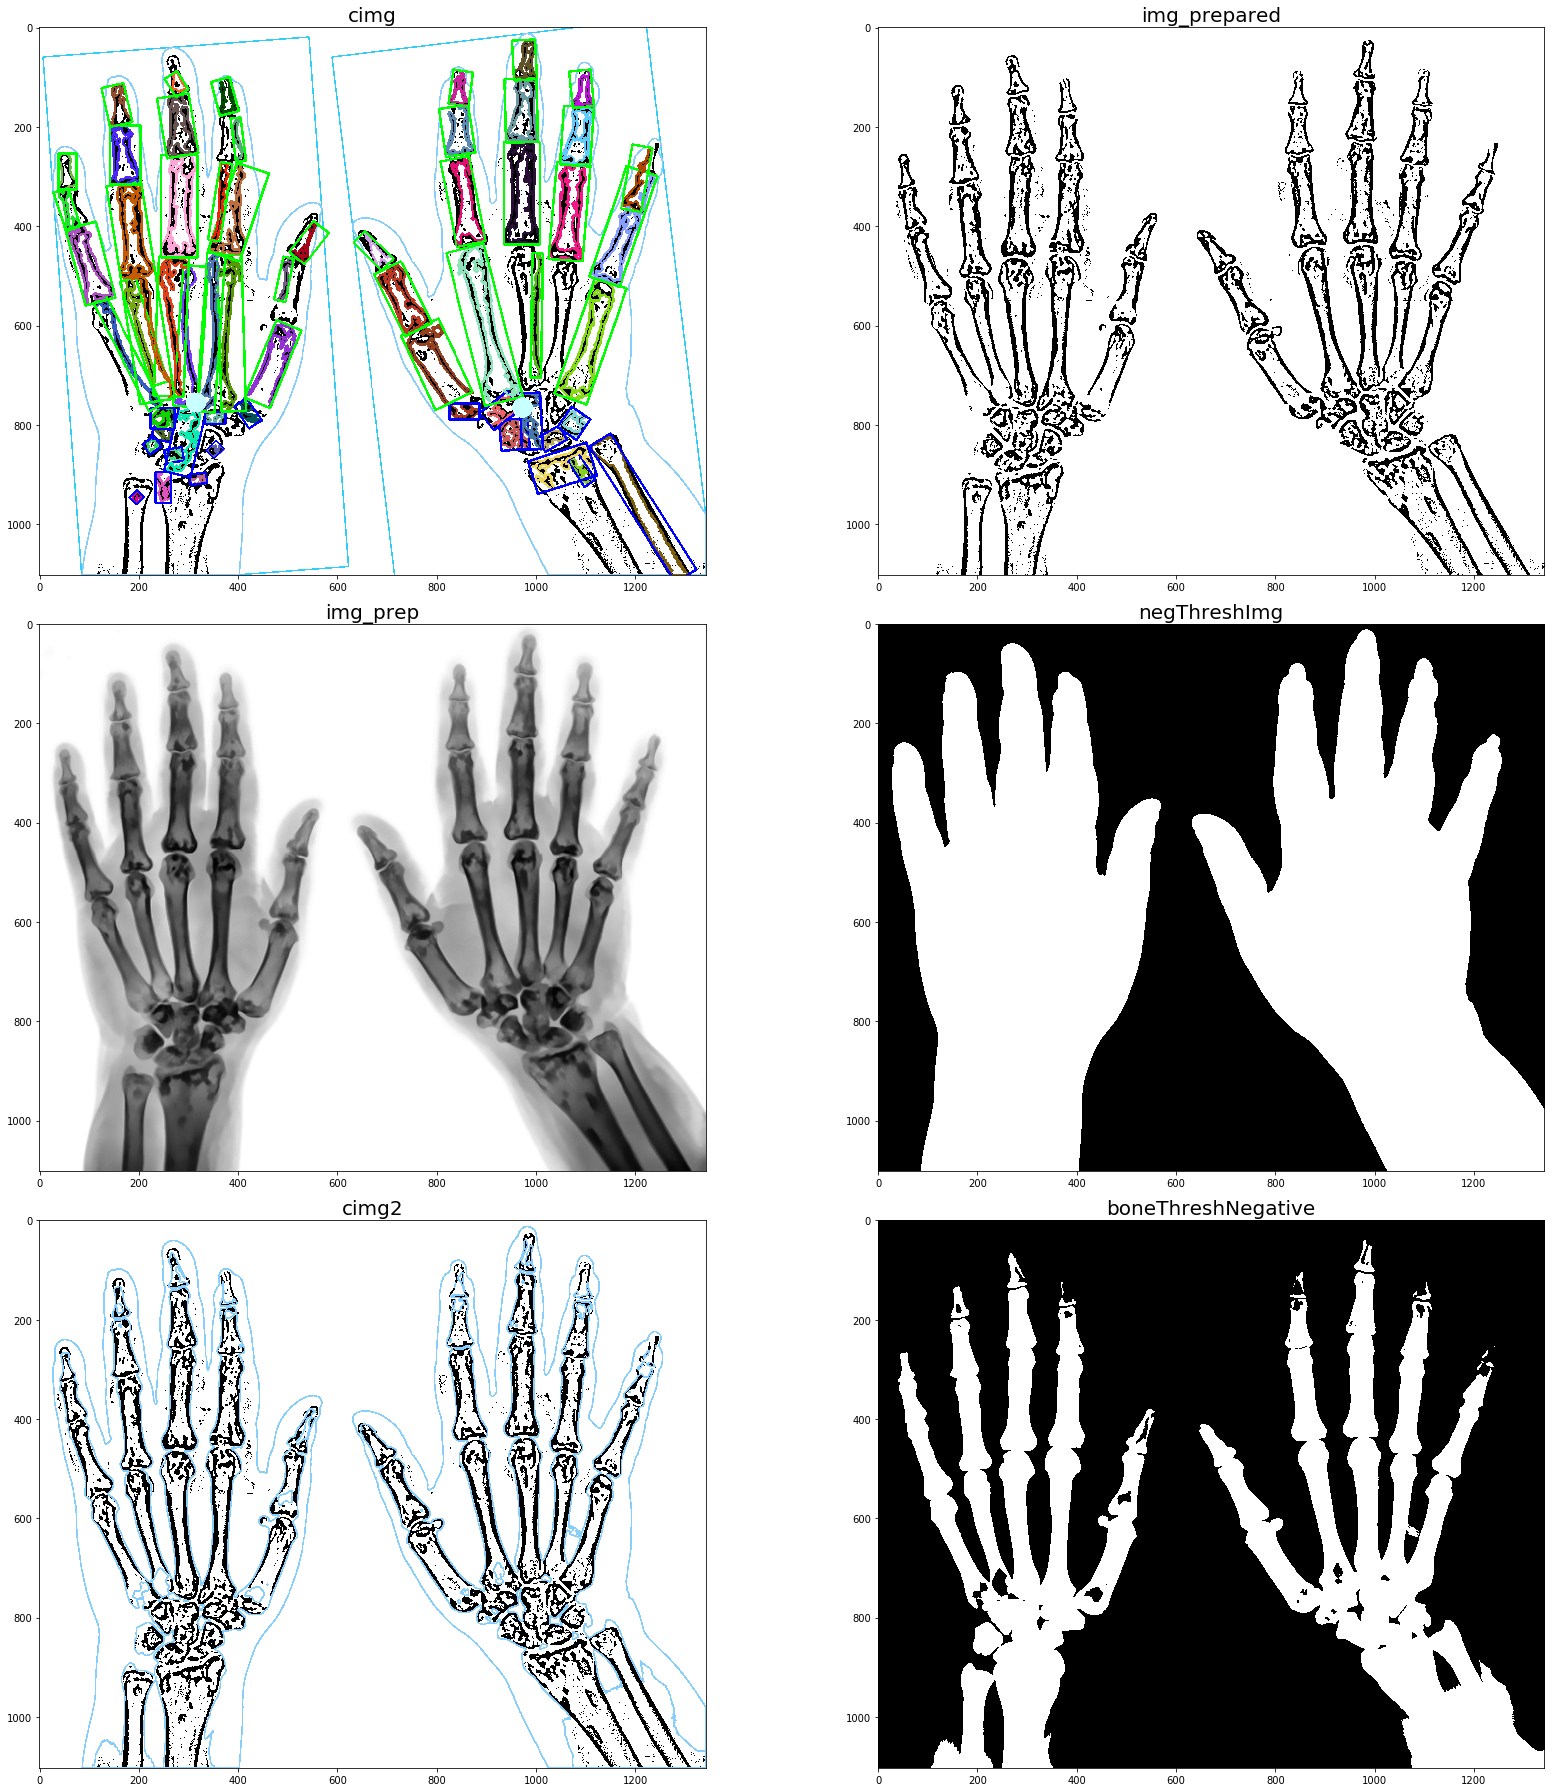

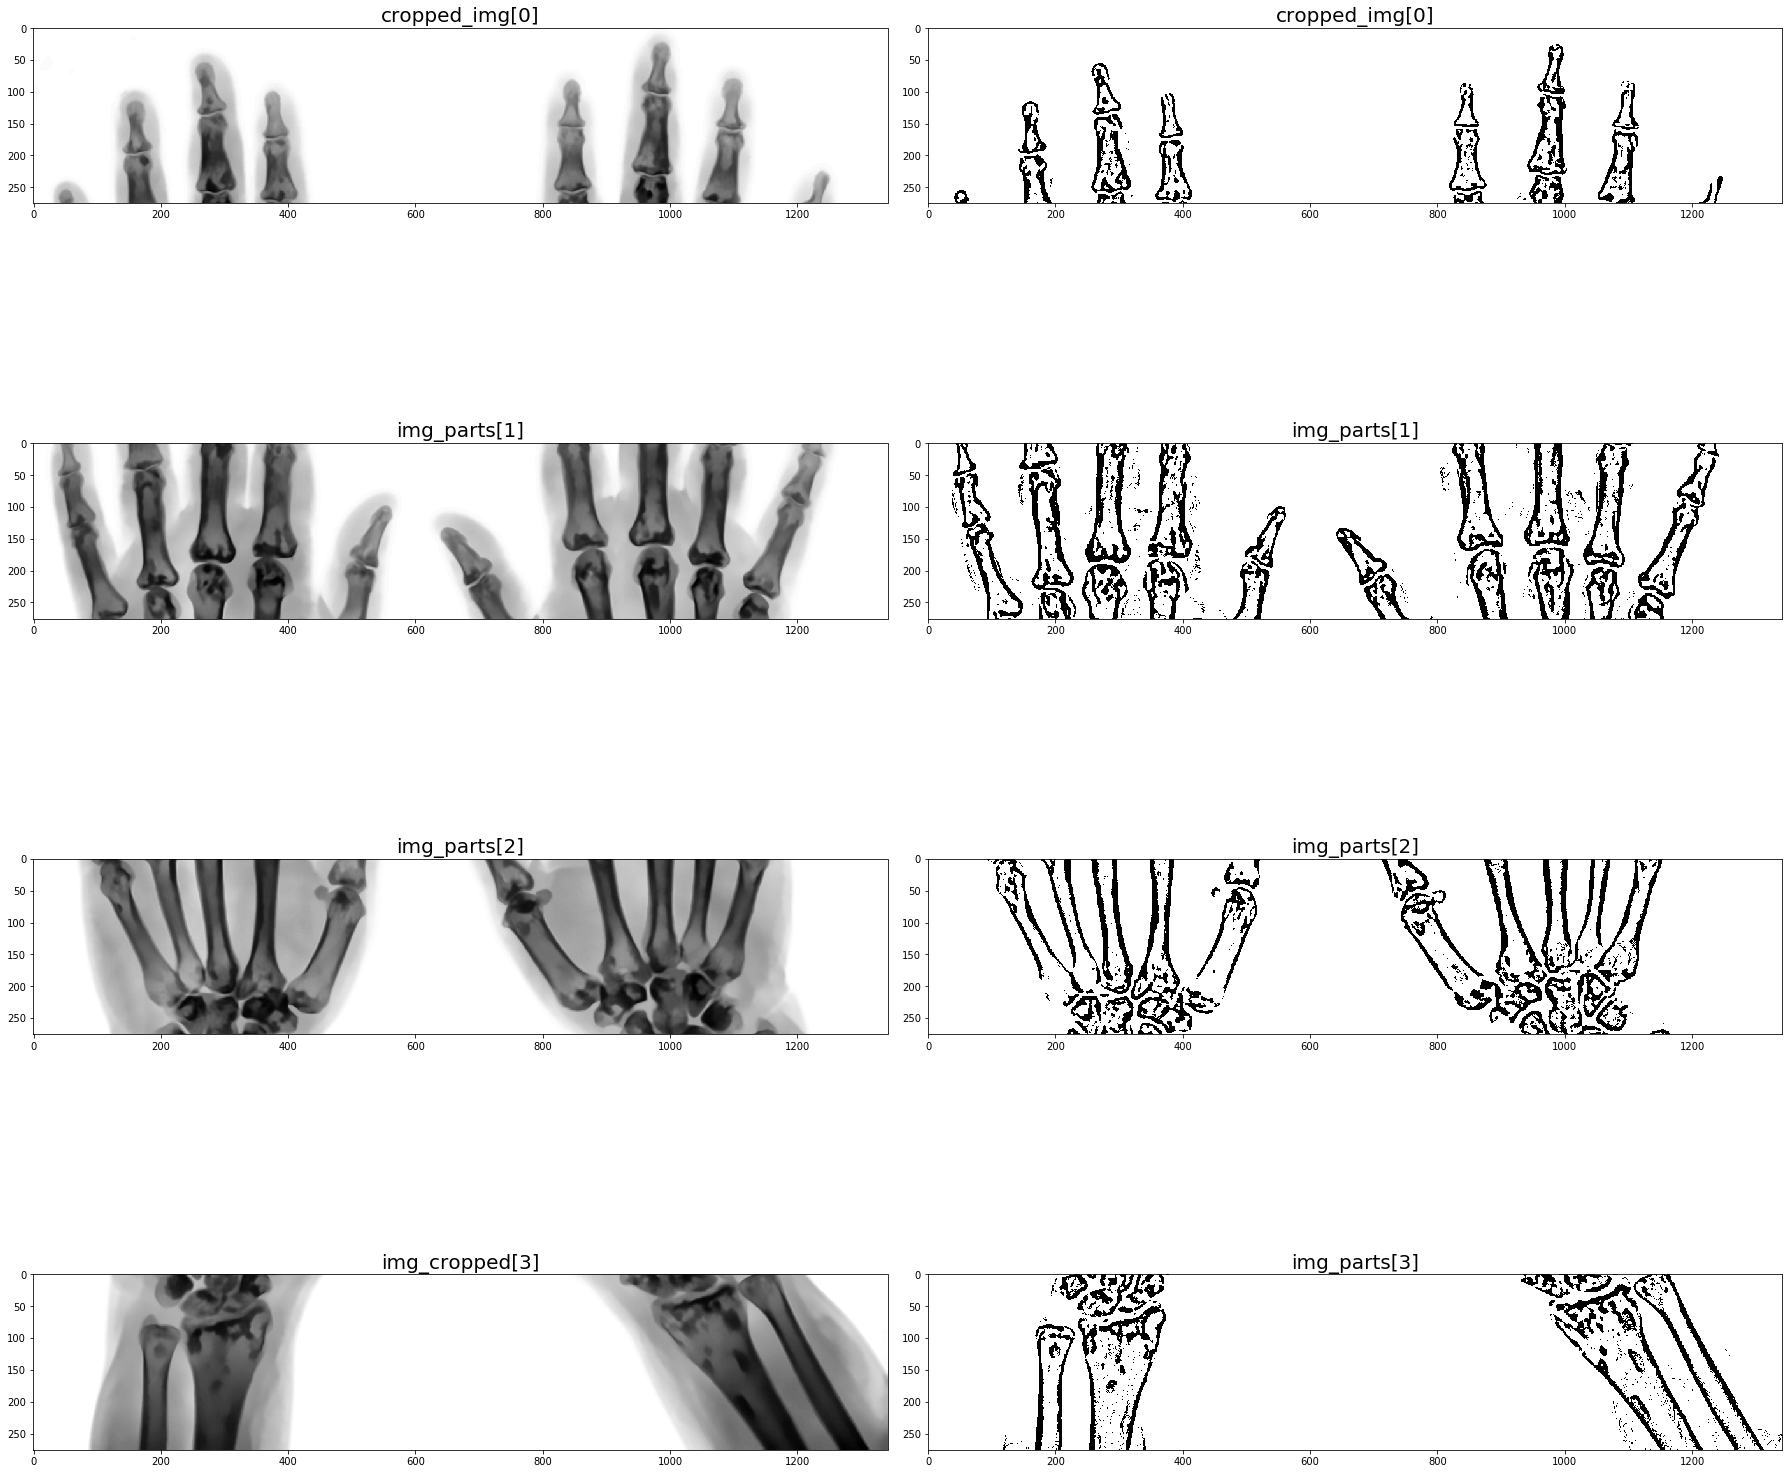

In [13]:
#
# 2. Finden Sie die Knochen und die Hand. Berechnen Sie dazu den Anteil der Knochen an der Gesamtfläche der Hand.
# 3. Berechnen Sie die Anzahl gesamten (einzelnen) Knochen.
# 4. Bonus: Berechnen Sie die zusätzlich zur Anzahl auch die maximale Länge jedes Knochens.
#
import math
import cv2 as cv
import cv2
import matplotlib.pyplot as plt
import numpy as np   
from skimage.filters import threshold_minimum
import random as rng
rng.seed(12345)

# Bild öffnen
img = plt.imread('roentgen.tif')
img = plt.imread('Testbild_Roentgen2.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.fastNlMeansDenoising(img, None,10,7,21)
img = cv2.bitwise_not(img)

# Bildvorverarbeitung
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
img_prep = clahe.apply(img)

height, width = img.shape[:2]

# Das Bild in x gleichgroße Teile einteilen und einzeln den threshold anwenden
# um den Farbverlauf innerhalb des Bildes auszugleichen
img_parts = []
img_cropped = []
partCnt = 4
assert partCnt >= 2
heightPart = (height / partCnt)
for i in range(partCnt):
    startY = int(heightPart * i)
    endY = int(heightPart * (i + 1))
    cropped_img = img_prep[startY:endY, 0:int(width)].copy()
    img_cropped.append(cropped_img.copy())
    cropped_img_thr = cropped_img

    thr, _ = cv2.threshold(cropped_img, 0, 255, cv2.THRESH_BINARY+cv.THRESH_OTSU)
    if(i == 2):
        newThr = (thr - (thr * 0.15))
    elif(i == 0):
        newThr = thr
    
    ret, cropped_img_thr = cv2.threshold(cropped_img, newThr, 255, cv2.THRESH_TRUNC)
    cropped_img_thr = cv2.adaptiveThreshold(cropped_img_thr, 255, cv2.ADAPTIVE_THRESH_MEAN_C  ,\
         cv2.THRESH_BINARY, 9, 2)

    img_parts.append(cropped_img_thr)

# Bilder wieder zusammenfügen
img_prepared = np.append(img_parts[0], img_parts[1], axis=0)
for i in range(partCnt):
    if(i >= 2):
        img_prepared = np.append(img_prepared, img_parts[i], axis=0)

# Hände finden
# dafür negThreshImg aus 1) verwenden
negThreshImg = prepareXRayImg(img)
handContours, _ = cv2.findContours(negThreshImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Kopien des Bildes für visualisierungen erstellen
cimg = cv2.cvtColor(img_prepared, cv2.COLOR_GRAY2BGR)
cimg2 = cv2.cvtColor(img_prepared, cv2.COLOR_GRAY2BGR)

# Anteil von Knochen an Hand berechnen
# findContours kann leider sehr ungenau sein, daher um die Fläche der Knochen zu berechnen lieber einen weiteren threashold 
# benutzen und nicht img_prepared
boneThresholdMin = threshold_minimum(img_prep)
_, boneThreshNegative = cv.threshold(img_prep, boneThresholdMin, 255, cv.THRESH_BINARY_INV)
looseBoneContours, _ = cv2.findContours(boneThreshNegative, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for boneArea in looseBoneContours:
    cv2.drawContours(cimg2, [boneArea], 0, (135,206,250), 2)

# Knochen finden
boneContours, _ = cv2.findContours(img_prepared, cv2.RETR_LIST, cv2.CHAIN_APPROX_TC89_L1)

imgHeight, imgWidth = img.shape
totalArea = imgHeight * imgWidth

handCounter = 1
for handArea in handContours:
    area = cv2.contourArea(handArea)
        
    # Bereich nur als Hand akzeptieren wenn Bereich mindestens 13%
    # des gesamten Bildes ausmacht
    percent = area / totalArea * 100
    if(percent > 13):
        print("Hand:", handCounter, area, str(round(percent, 2)) + "%")
        
        # "Mittelpunkt" der Hand berechnen
        cX, cY = calculateCenterPoint(handArea)
        cY = int(cY * 1.1)
        
        # Höhe und Breite der handContours berechnen
        handAreaRect = cv2.minAreaRect(handArea)
        handAreaX = handAreaRect[0][0]
        handAreaY = handAreaRect[0][1]
        handAreaWidth = handAreaRect[1][0]
        handAreaHeight = handAreaRect[1][1]
        handAreaBox = cv2.boxPoints(handAreaRect)
        handAreaBox = handAreaBox.astype('int')
        cv2.drawContours(cimg, contours = [handAreaBox], 
                            contourIdx = -1, 
                             color = (50,206,250), thickness = 2)
        
        # Hand zeichnen
        cv2.drawContours(cimg, [handArea], 0, (135,206,250), 2)
        cv2.drawContours(cimg2, [handArea], 0, (135,206,250), 2)
        
        # Anteil an Knochen relativ zur Hand berechnen
        totalBoneForHand = 0
        for boneArea in looseBoneContours:
            looseBoneRect =  cv2.minAreaRect(boneArea)
            isInHand = cv2.pointPolygonTest(handArea, (looseBoneRect[0][0], looseBoneRect[0][1]), False)
            if(isInHand == 1.0):
                totalBoneForHand += cv2.contourArea(boneArea)
        bonePercent = totalBoneForHand / area * 100
        print("Hand ", handCounter, " Bereich Gesamt:", area, '-->', "davon Knochen:",
              str(round(bonePercent, 2)) + "%", "(" +  str(totalBoneForHand) + ")")

        # Schwellenwerte relative zur handArea Größe berechnen
        # um verschiedenste Bildgrößen zu unterstützen
        handAreaMinLen = min(handAreaWidth, handAreaHeight)
        THRESH_MERGE_DIST = int(handAreaMinLen * 0.053380782)
        THRESH_BONE_HEIGHT = int(handAreaMinLen * 0.035587188)
        THRESH_BONE_WIDTH = int(handAreaMinLen * 0.035587188)
        print("Schwellenwert THRESH_MERGE_DIST: " + str(THRESH_MERGE_DIST))
        print("Schwellenwert THRESH_BONE_HEIGHT: " + str(THRESH_BONE_HEIGHT))
        print("Schwellenwert THRESH_BONE_WIDTH: " + str(THRESH_BONE_WIDTH))
              
        # Liste an Knochen für diese Hand
        boneList = []
        
        # Knochen Kanten für handArea filtern
        i = 0
        for boneContour in boneContours:
            
            # Rechteck mit Rotation an Kontur anlegen
            # ( center (x,y), (width, height), angle of rotation )
            # Achtung: width ist nicht immer die Seite mit dem kleinsten
            #          Winkel zur x-Achse
            boneRect = cv2.minAreaRect(boneContour)
            
            x = boneRect[0][0]
            y = boneRect[0][1]
            rotation = boneRect[2]
            height = boneRect[1][0]
            width = boneRect[1][1]
            
            # debug highlight
            #debugPos = (71.71719360351562, 236.41848754882812)
            #debugPos = (int(debugPos[0]), int(debugPos[1]))
            #if(int(x) == debugPos[0] and int(y) == debugPos[1]):
            #    cv2.circle(cimg, debugPos, 50, (200, 255, 255), 10)
            
            # rotations Winkel in eine verständlichere Form umrechnen
            if(width < height):
                rotation = rotation + 180
            else:
                rotation = rotation + 90
            
            # Prüfen ob knochen innerhalb der Hand Area liegt
            # Könnten hier auch mit Masken arbeiten um performance weiter zu verbessern
            dist = cv2.pointPolygonTest(handArea,(x, y), True)
            if(dist < -20): # kleine Toleranz erlauben
                continue;
            
            # Seiten Verhältnis berechnen
            minSeite = min(width, height)
            maxSeite = max(width, height)
            if(minSeite != 0):
                v = (maxSeite / minSeite)
            else:
                v = 0
                    
            # äußere Bildkante und zu kleine Boxen auschließen        
            isSizeValid = height < (img.shape[0] - 5) and height > THRESH_BONE_HEIGHT and width > THRESH_BONE_WIDTH
                    
            if not isSizeValid:
                continue;
            
            # boneRect in äußeres kordinaten Box-Format umwandeln 
            boneBox = cv2.boxPoints(boneRect)
            boneBox = boneBox.astype('int')
            
            # mögliche Artefakte bei den Fingerkuppen ignorieren
            # nur innerhalb den oberen X% von handAreaRect anwenden
            if(y < (handAreaY - int((handAreaHeight / 2) * 0.3)) and (rotation < 50 or rotation > 130)):
                continue;
            
            boneType = None
            boxColor = None
            
            # Knochen die außerhalb des Bildes reichen, gelten als Armknochen
            isArmBone = False
            for point in boneBox:
                if(point[0] > imgWidth or point[1] > imgHeight or point[0] < 0 or point[1] < 0):
                    isArmBone = True
                    break
            if(isArmBone):
                # Elle und Speiche
                boneType = "arm"
                boneColor = (0, 0, 255)    
            # wenn gefundener Knochen unterhalb der Handmitte muss er ein bestimmtes mindest Seitenverhältnis und
            # einen bestimmten Rotations Bereich haben
            # um als Fingerknochen zu gelten
            elif(cY > y or (cY < y and v > 3 and rotation > 40 and rotation < 140)):
                # Finger und Mittelknochen
                
                # zu rechteckige Boxen ausschließen
                if(v < 1.3):
                    continue;
                boneType = "finger"
                boneColor = (0, 255, 0)
            else:
                # andere Knochen (Carpal Bones)
                boneType = "other"
                boneColor = (0, 0, 255)
            
            bone = Bone(x, y, width, height, boneType)
            bone.contour = boneContour
            bone.box = boneBox
            bone.rotation = rotation
            bone.v = v
            boneList.append(bone)
        
        # bone Ergebnisse zusammenführen
        filteredBoneList = []
        for bone in boneList:
            useBone = True
            for searchBone in filteredBoneList:
                boneDist = math.hypot(bone.x - searchBone.x, bone.y - searchBone.y)
                if(boneDist < THRESH_MERGE_DIST):
                    useBone = False
                    break
            if(useBone):
                filteredBoneList.append(bone)
        print(len(boneList) - len(filteredBoneList), "Knochen zusammengeführt")
        boneList = filteredBoneList             
               
        # Alle Knochen zeichnen
        for bone in boneList:
            boneColor = None
            if(bone.boneType == "finger"):
                boneColor = (0, 255, 0)
            else:
                boneColor = (0, 0, 255)
                
            print("Knochen typ:", bone.boneType.rjust(9), "\t Länge: ", str(round(max(bone.height, bone.width), 1)).rjust(9),
                  "Rotation: ", str(round(bone.rotation, 1)).rjust(9), "Seiten Verhältnis:", round(bone.v, 2))
            color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
            cv2.drawContours(cimg, [bone.contour], 0, color, 3)

            cv2.drawContours(cimg, contours = [bone.box], contourIdx = -1, color = boneColor, thickness = 3)
        
        print("Anzahl gefundener Finger- und Mittelhandknochen: " + str(sum(b.boneType == "finger" for b in boneList)))
        print("(Anzahl Armknochen: " + str(sum(b.boneType == "arm" for b in boneList)) + ")")
        print("Anzahl sonstiger Knochen (Handwurzel): " + str(sum(b.boneType == "other" for b in boneList)))
                    
        handCounter += 1
        
        # Mittelpunkt der Hand zeichnen
        cv2.circle(cimg, (cX, cY), 10, (200, 255, 255), 20)
        
        print("-----------------")
    
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25,25))
ax = axes.ravel()

ax[0].imshow(cimg, cmap='gray', interpolation='nearest')
ax[0].set_title('cimg', fontsize=20)

ax[1].imshow(img_prepared, cmap='gray')
ax[1].set_title('img_prepared', fontsize=20)

ax[2].imshow(img_prep, cmap='gray')
ax[2].set_title('img_prep', fontsize=20)

ax[3].imshow(negThreshImg, cmap='gray')
ax[3].set_title('negThreshImg', fontsize=20)


ax[4].imshow(cimg2, cmap="gray")
ax[4].set_title('cimg2', fontsize=20)

ax[5].imshow(boneThreshNegative, cmap="gray")
ax[5].set_title('boneThreshNegative', fontsize=20)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25,25))
ax = axes.ravel()

ax[0].imshow(img_cropped[0], cmap='gray')
ax[0].set_title('cropped_img[0]', fontsize=20)

ax[1].imshow(img_parts[0], cmap='gray')
ax[1].set_title('cropped_img[0]', fontsize=20)

ax[2].imshow(img_cropped[1], cmap='gray')
ax[2].set_title('img_parts[1]', fontsize=20)

ax[3].imshow(img_parts[1], cmap='gray')
ax[3].set_title('img_parts[1]', fontsize=20)

ax[4].imshow(img_cropped[2], cmap='gray')
ax[4].set_title('img_parts[2]', fontsize=20)

ax[5].imshow(img_parts[2], cmap='gray')
ax[5].set_title('img_parts[2]', fontsize=20)

ax[6].imshow(img_cropped[3], cmap='gray')
ax[6].set_title('img_cropped[3]', fontsize=20)

ax[7].imshow(img_parts[3], cmap='gray')
ax[7].set_title('img_parts[3]', fontsize=20)

plt.tight_layout()
plt.show()


### Achtung:

1. Die Lösung soll gelten für:
    - beliebig große Bilder (Zeilen- und Spaltenanzahl)
    - andere Bilder als das Testbild (z.B. `Testbild_Roentgen2.jpg`), jedoch in demselben Bildtyp (Grau- oder Farbbild) und mit derselben Art von Objekten
    - Objekte an beliebiger Stelle im Bild (auch Objekte an Rändern und Ecken können vorkommen!). „Unvollständige“ Objekte müssen allerdings nicht berücksichtigt werden. Also berücksichtigen Sie bitte, anders als in den Übungen, auch die Sonderfälle. 
    

2. Der Quellcode wird für die Benotung auch an anderen Bildern als diesen Testbildern getestet!


3. Bewertet werden:
    - Das Ergebnis (Anzahl gefundener Objekte, Ergebnis der Analysen, etc.)
    - Der Lösungsweg (Programmaufbau, Geschwindigkeit, benutzte Algorithmen)
    - Fehlerresistenz und Allgemeingültigkeit (Test mit anderen Bildern)
